### Load data and import necessary library

In [1]:
#Import necessary librarier
import pickle as pkl
from itertools import cycle
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from xgboost import XGBClassifier
from scipy.stats import zscore, norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

In [3]:
# Import data
task1 = pd.read_csv('./converted_data/converted_data.csv')
task2 = pd.read_csv('./converted_data/df_labels_balanced_converted.csv')

In [4]:
task1.head()

,iscancerous,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p2177,p2178,p2179,p2180,p2181,p2182,p2183,p2184,p2185,p2186
0,0,164,124,180,146,108,169,172,134,199,...,222,163,115,188,160,113,185,168,122,191
1,0,241,236,240,242,234,239,240,229,237,...,158,151,107,179,138,91,175,101,54,142
2,0,250,240,252,254,244,255,239,228,246,...,230,243,216,237,239,209,231,246,213,238
3,0,255,237,255,243,224,242,238,222,233,...,187,202,118,163,183,97,147,200,114,167
4,0,222,198,219,230,204,227,218,186,215,...,245,244,212,229,241,204,226,235,195,221


## Evaluation Metrics

In [5]:
def plot_multiclass_roc(clf, X_test, y_test):
    figsize=(17, 6)
    y_score = clf.predict_proba(X_test)
    # y_score = clf.predict(X_test)
    n_classes = len(np.unique(y_test))


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    # y_test_dummies = y_test
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


In [6]:
from sklearn.metrics import RocCurveDisplay
# Use this function to train and evaluate the model. If the model is a neural network, 
# change model_type to 'tf' and specified the trainning epochs
def train_and_plot(model, X_train , y_train, X_test, y_test, model_type = 'sk', epochs = 0):

    if model_type == 'sk' :
        model.fit(X_train, y_train)
        print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
        print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
        
        # fpr, tpr, thresholds = macro_roc(y_test, model.predict(X_test), n_classes = len(y_train.value_counts()))
        # roc_curve(y_test, model.predict_proba(X_test)[:,1])
    elif model_type == 'tf' :
        model.fit(X_train, y_train, epochs = epochs, verbose = 2)
        print('Model accuracy for train set: {0:.3f}'.format(model.evaluate(X_train, y_train, verbose=0)[1]))
        print('Model accuracy for test set: {0:.3f}'.format(model.evaluate(X_test, y_test, verbose=0)[1]))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

                           
    plt.title('Confusion Matrix')

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', auc.round(3))
    
    plot_multiclass_roc(model, X_test, y_test)
    

    
    return model

## Traditional Machine learning model

In [7]:
def set_gen(input_df, key = 'iscancerous') :
    X = input_df.drop(key, axis = 1)
    y = input_df[key]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, shuffle = True, stratify = y)
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = set_gen(task1)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18270, 2187)
(18270,)
(7830, 2187)
(7830,)


## Trainning ensemble model

## Task 1

In [10]:


# Instantiate the individual models with their parameters
lgbm = LGBMClassifier(n_jobs = -1)
xgb = XGBClassifier(n_jobs = -1)

best_params = {'xgboost__colsample_bytree': 0.9933990872908748,
 'xgboost__gamma': 0.16773175473025118,
 'xgboost__learning_rate': 0.138201994909766,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 3,
 'xgboost__n_estimators': 442,
 'xgboost__reg_alpha': 0.15070071468168292,
 'xgboost__reg_lambda': 0.99558474460022,
 'xgboost__subsample': 0.6614827304636092,
 'lightgbm__colsample_bytree': 0.20484766341576388,
 'lightgbm__gamma': 0.00015734088482487662,
 'lightgbm__learning_rate': 0.16373614835494935,
 'lightgbm__max_depth': 8,
 'lightgbm__min_child_weight': 2,
 'lightgbm__n_estimators': 470,
 'lightgbm__reg_alpha': 0.02162930151649487,
 'lightgbm__reg_lambda': 1.4797282426704635e-05,
 'lightgbm__subsample': 0.08975167648738613}

# Create a list of the models
models = [('lightgbm', lgbm), ('xgboost', xgb)]

for name, model in models:
    for key, value in best_params.items():
        if key.startswith(name):
            model.set_params(**{key.split('__')[-1]: value})

# Instantiate the ensemble model
ensemble = VotingClassifier(models)
# ensemble.set_params(best_params)

In [11]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ensemble', ensemble)
])

In [12]:
param_grid = {
    'ensemble__voting': ['soft'],
    'ensemble__weights' : [[1,2],[2,1],[1,1]]
}

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown param

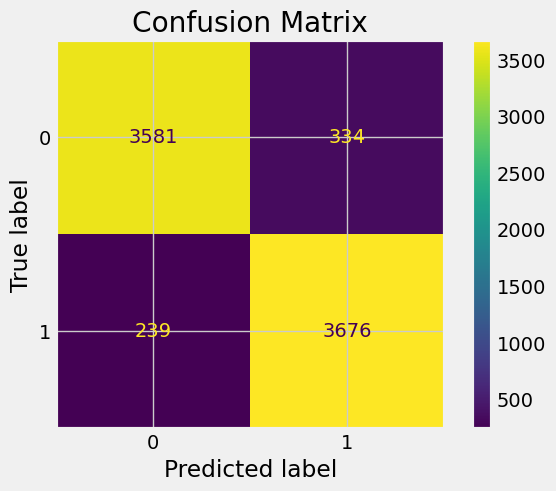

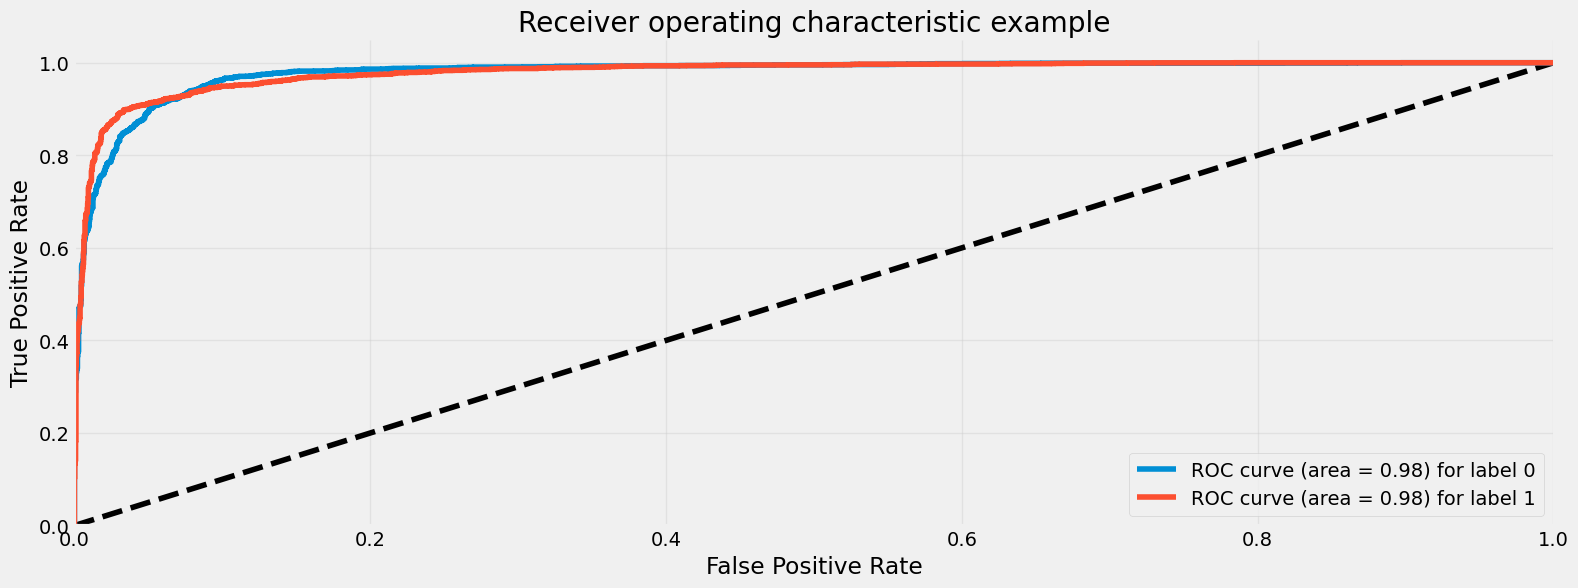

In [15]:
grid = GridSearchCV(pipe, param_grid, cv=10)
# grid.fit(X_train, y_train)
res = train_and_plot(grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [17]:
params_ensemble = grid.best_params_
print(params_ensemble)

{'ensemble__voting': 'soft', 'ensemble__weights': [2, 1]}


In [23]:
res_params = {'ensemble__voting': 'soft', 'ensemble__weights': [2, 1]}

In [24]:
best_ensemble_task1 = grid.best_estimator_

In [25]:
pipe.set_params(**res_params)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ensemble',
                 VotingClassifier(estimators=[('lightgbm',
                                               LGBMClassifier(colsample_bytree=0.20484766341576388,
                                                              gamma=0.00015734088482487662,
                                                              learning_rate=0.16373614835494935,
                                                              max_depth=8,
                                                              min_child_weight=2,
                                                              n_estimators=470,
                                                              reg_alpha=0.02162930151649487,
                                                              reg_lambda=1.4797282426704635e-05,
                                                              subsample=0.0897516764873861...
                                                          

Model accuracy for train set: 1.000
Model accuracy for test set: 0.927

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3915
           1       0.92      0.94      0.93      3915

    accuracy                           0.93      7830
   macro avg       0.93      0.93      0.93      7830
weighted avg       0.93      0.93      0.93      7830


Confusion Matrix:
 [[3581  334]
 [ 239 3676]]

Accuracy Score:  0.927


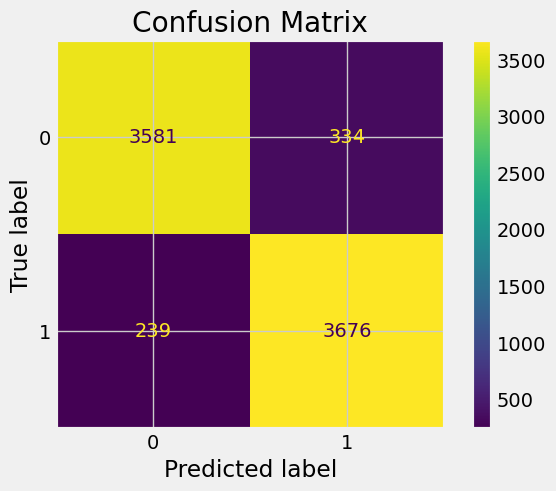

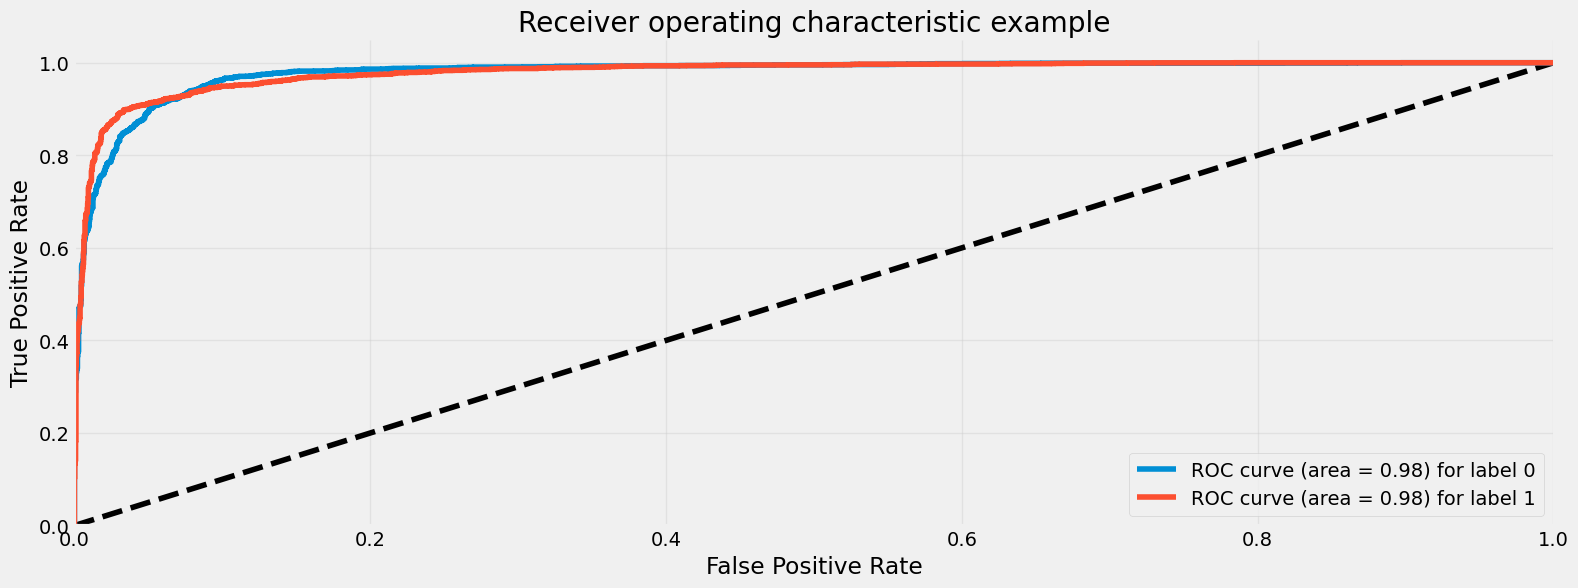

In [26]:
res_task1_ensemble = train_and_plot(pipe, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [ ]:
with open("./model_result/res_task1_ensemble.pkl", "wb") as f:
    pkl.dump(res_task1_ensemble, f)

## Task 2

In [10]:
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = set_gen(task2, key = 'celltype')
print(X_train_task2.shape)
print(y_train_task2.shape)
print(X_test_task2.shape)
print(y_test_task2.shape)

(11376, 2187)
(11376,)
(4876, 2187)
(4876,)


## Task 2

## Tunning Ensemble Model

In [18]:
lgbm = LGBMClassifier(n_jobs = -1)
xgb = XGBClassifier(n_jobs = -1)

best_params = {'xgboost__colsample_bytree': 0.9933990872908748,
 'xgboost__gamma': 0.16773175473025118,
 'xgboost__learning_rate': 0.138201994909766,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 3,
 'xgboost__n_estimators': 442,
 'xgboost__reg_alpha': 0.15070071468168292,
 'xgboost__reg_lambda': 0.99558474460022,
 'xgboost__subsample': 0.6614827304636092,
 'lgbm__bagging_fraction': 0.8635734699884771,
 'lgbm__bagging_freq': 4,
 'lgbm__feature_fraction': 0.9840355098240596,
 'lgbm__lambda_l1': 0.011508037597462427,
 'lgbm__lambda_l2': 1.1301506734594464e-08,
 'lgbm__min_child_samples': 68,
 'lgbm__num_leaves': 248}
# Create a list of the models
models = [('lgbm', lgbm), ('xgboost', xgb)]

for name, model in models:
    for key, value in best_params.items():
        if key.startswith(name):
            model.set_params(**{key.split('__')[-1]: value})

# Instantiate the ensemble model
ensemble_2 = VotingClassifier(models)
# ensemble.set_params(best_params)

In [19]:
pipe_2 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ensemble', ensemble_2)
])

In [20]:
param_grid = {
    'ensemble__voting': ['soft'],
    'ensemble__weights' : [[1,2],[2,1],[1,1]]
}

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.011508037597462427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011508037597462427
[LightGBM] [Warning] feature_fraction is set=0.9840355098240596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840355098240596
[LightGBM] [Warning] bagging_fraction is set=0.8635734699884771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8635734699884771
[LightGBM] [Warning] lambda_l2 is set=1.1301506734594464e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1301506734594464e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.011508037597462427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011508037597462427
[LightGBM] [Warning] feature_fraction is set=0.9840355098240596, co

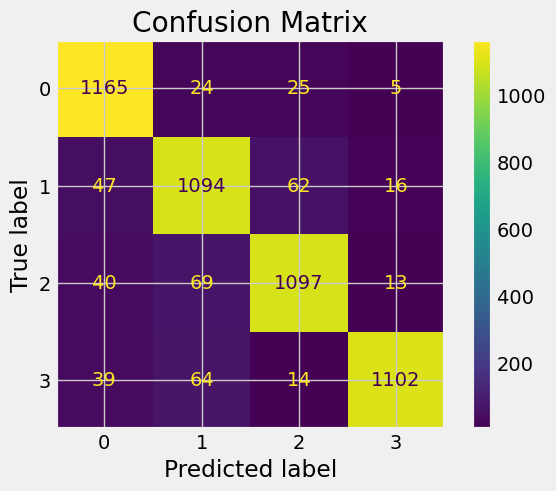

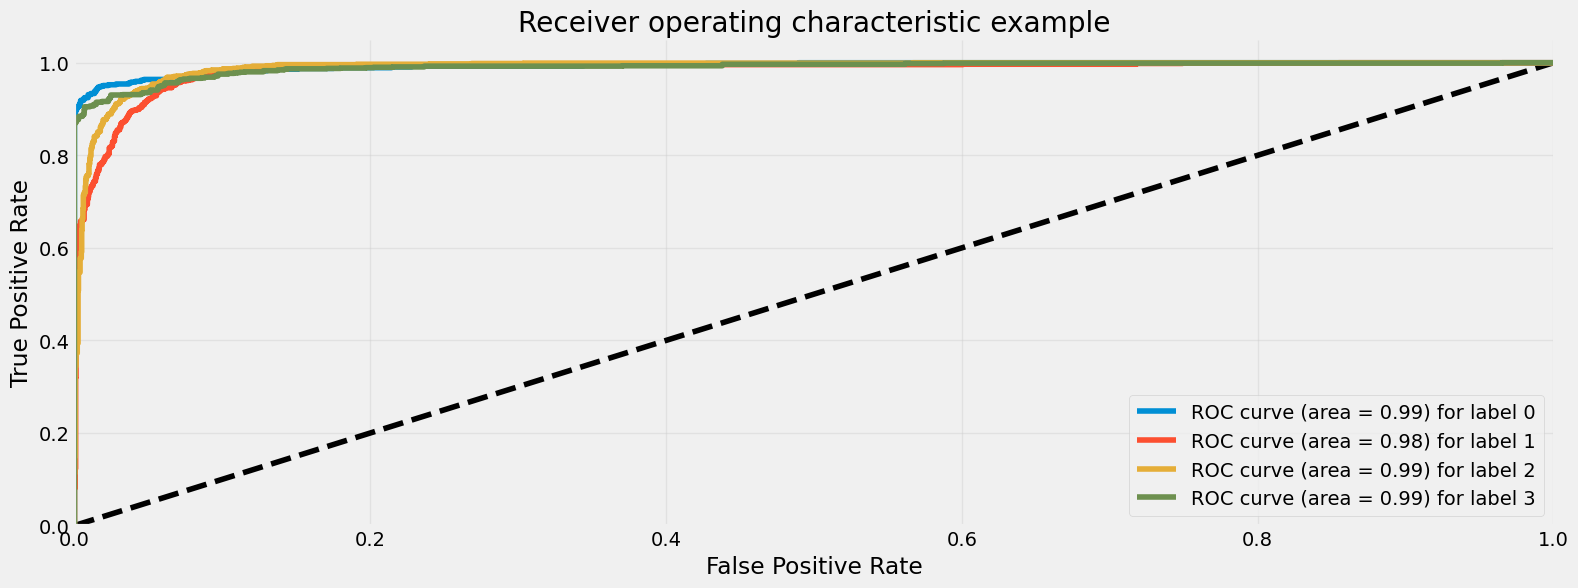

In [23]:
grid = GridSearchCV(pipe_2, param_grid, cv=10)
# grid.fit(X_train, y_train)
res = train_and_plot(grid, X_train = X_train_task2, X_test = X_test_task2, y_train = y_train_task2, y_test = y_test_task2)

## Tunning result

In [25]:
params_ensemble = grid.best_params_
print(params_ensemble)

{'ensemble__voting': 'soft', 'ensemble__weights': [1, 2]}


In [26]:
best_ensemble_task2 = grid.best_estimator_

## Retrain the pipeline

In [27]:
pipe_2.set_params(**params_ensemble)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ensemble',
                 VotingClassifier(estimators=[('lgbm',
                                               LGBMClassifier(bagging_fraction=0.8635734699884771,
                                                              bagging_freq=4,
                                                              feature_fraction=0.9840355098240596,
                                                              lambda_l1=0.011508037597462427,
                                                              lambda_l2=1.1301506734594464e-08,
                                                              min_child_samples=68,
                                                              num_leaves=248)),
                                              ('xgboost',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                               

In [ ]:
res_task2_ensemble = train_and_plot(pipe_2,X_train = X_train_task2, X_test = X_test_task2, y_train = y_train_task2, y_test = y_test_task2)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.011508037597462427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011508037597462427
[LightGBM] [Warning] feature_fraction is set=0.9840355098240596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840355098240596
[LightGBM] [Warning] bagging_fraction is set=0.8635734699884771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8635734699884771
[LightGBM] [Warning] lambda_l2 is set=1.1301506734594464e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1301506734594464e-08


In [ ]:
with open("./model_result/res_task2_ensemble.pkl", "wb") as f:
    pkl.dump(res_task2_ensemble, f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d871b9e-4e37-4fce-a22e-8733be6e4afc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>